In [1]:
import pandas as pd
import numpy as np
import requests as rq
import json
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
industry_map = {
    'Manufacture of fabricated metal products, except machinery and equipment': 'fab_metal_manuf',
    'Activities of membership organisations': 'member_activity', 
    'Employment activities': 'employ_activity',
    'Human health activities': 'health_activity',
    'Water collection, treatment and supply': 'water_treatment',
    'Office administrative, office support and other business support activities': 'office_admin',
    'Manufacture of food products': 'food_manuf', 
    'Accommodation': 'accommodation',
    'Other professional, scientific and technical activities': 'other_professional',
    'Crop and animal production, hunting and related service activities': 'animal_product',
    'Legal and accounting activities': 'legal_accounting',
    'Insurance, reinsurance and pension funding, except compulsory social security': 'insurance',
    'Public administration and defence; compulsory social security': 'public_service',
    'Information service activities': 'info_tech',
    'Wholesale and retail trade and repair of motor vehicles and motorcycles': 'vehicle_services',
    'Residential care activities': 'resident_care',
    'Libraries, archives, museums and other cultural activities': 'cultural_services',
    'Travel agency, tour operator and other reservation service and related activities': 'travel_services',
    'Education': 'education',
    'Retail trade, except of motor vehicles and motorcycles': 'retail',
    'Architectural and engineering activities; technical testing and analysis': 'architect_engineer',
    'Computer programming, consultancy and related activities': 'computer_programming',
    'Real estate activities': 'real_estate',
    'Financial service activities, except insurance and pension funding': 'financial_services',
    'Social work activities without accommodation': 'social_work',
    'Food and beverage service activities': 'food_service',
    'Construction of buildings': 'building_construction',
    'Activities of head offices; management consultancy activities': 'management',
    'Advertising and market research': 'advertising',
    'Sports activities and amusement and recreation activities': 'sports_recreation',
    'Warehousing and support activities for transportation': 'warehousing_transport',
    'Manufacture of other non-metallic mineral products': 'mineral_manuf',
    'Rental and leasing activities': 'rental_activity',
    'Specialised construction activities': 'special_construction', 
    'Publishing activities': 'publishing',
    'Wholesale trade, except of motor vehicles and motorcycles': 'wholesale_trade',
    'Manufacture of computer, electronic and optical products': 'electronic_manuf',
    'Services to buildings and landscape activities': 'building_services',
    'Other personal service activities': 'other_services',
    'Postal and courier activities': 'postal',
    'Electricity, gas, steam and air conditioning supply': 'utilities_supply',
    'Security and investigation activities': 'security',
    'Waste collection, treatment and disposal activities; materials recovery': 'waste_management',
    'Undifferentiated goods- and services-producing activities of private households for own use': 'consumer_goods',
    'Manufacture of chemicals and chemical products': 'chemical_manuf',
    'Manufacture of textiles': 'textile_manuf',
    'Activities auxiliary to financial services and insurance activities': 'financial_related',
    'Civil engineering': 'civil_engineer', 
    'Telecommunications': 'telecom',
    'Manufacture of electrical equipment': 'elec_equip_manuf',
    'Repair of computers and personal and household goods': 'goods_repair',
    'Manufacture of basic pharmaceutical products and pharmaceutical preparations': 'pharma_manuf',
    'Remediation activities and other waste management services': 'waste_remediation',
    'Repair and installation of machinery and equipment': 'installation',
    'Manufacture of machinery and equipment nec': 'machine_manuf',
    'Manufacture of leather and related products': 'leather_manuf',
    'Scientific research and development': 'science_rd', 
    'Forestry and logging': 'forestry',
    'Other manufacturing': 'other_manuf', 
    'Manufacture of other transport equipment': 'transport_manuf',
    'Programming and broadcasting activities': 'broadcasting', 
    'Air transport': 'air_transport',
    'Motion picture, video and television programme production, sound recording and music publishing activities': 'media_production',
    'Creative, arts and entertainment activities': 'entertainment_activity',
    'Extraction of crude petroleum and natural gas': 'oil_gas_manuf',
    'Manufacture of beverages': 'beverage_manuf',
    'Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials': 'wood_manuf',
    'Manufacture of motor vehicles, trailers and semi-trailers': 'vehicle_manuf',
    'Manufacture of furniture': 'furniture_manuf',
    'Land transport and transport via pipelines': 'pipe_transport',
    'Activities of households as employers of domestic personnel': 'domestic',
    'Printing and reproduction of recorded media': 'media_reproduction',
    'Manufacture of wearing apparel': 'clothes_manuf', 
    'Veterinary activities': 'veterinary_activity',
    'Activities of extraterritorial organisations and bodies': 'foreign_service',
    'Other mining and quarrying': 'other_mining', 
    'Water transport': 'water_transport',
    'Manufacture of basic metals': 'basic_metal_manuf', 
    'Gambling and betting activities': 'gambling',
    'Mining of coal and lignite': 'coal_mining', 
    'Fishing and aquaculture': 'fishing',
    'Manufacture of paper and paper products': 'paper_manuf',
    'Manufacture of rubber and plastic products': 'plastic_manuf',
    'Mining support service activities': 'mining_services',
    'Manufacture of coke and refined petroleum products': 'petrol_manuf',
    'Sewerage': 'sewerage',
    'Mining of metal ores': 'metal_mining',
    'nan': ''
}
main_df = pd.read_csv('main.csv')
main_df['INDUSTRY'] = main_df['INDUSTRY'].map(lambda x: '' if pd.isna(x) else industry_map[x])

# Creating an Occupation Network by Specialized Skill Overlap

In [3]:
green_df = pd.read_csv('greens.csv')

code_map = {}

for code in green_df['O*NET-SOC Code']:

    res = rq.get(f'http://api.lmiforall.org.uk/api/v1/o-net/onet2soc?onetCodes={code}')
    js = json.loads(res.content)
    
    if len(js) > 0: code_map[code] = code_map[code] = [x['soc'] for x in js[0]['socCodes']]

green_soc = np.unique([item for sublist in code_map.values() for item in sublist])
main_df['green'] = main_df['SOC_4'].map(lambda x: x in green_soc)

In [4]:
sub_df = main_df[['SOC_4_NAME', 'SPECIALIZED_SKILLS_NAME', 'green']].copy()
sub_df['SPECIALIZED_SKILLS_NAME'] = sub_df['SPECIALIZED_SKILLS_NAME'] \
    .map(lambda x: '' if x is None else [y.strip() for y in x.replace('"', '').replace(",","").split('\n')[1:-1]])

long_df = sub_df.explode('SPECIALIZED_SKILLS_NAME').groupby(['SOC_4_NAME', 'SPECIALIZED_SKILLS_NAME']).agg({'SPECIALIZED_SKILLS_NAME': 'count'})

clean_df = pd.DataFrame({
    'occupation': [x[0] for x in list(long_df.index)],
    'skill': [x[1] for x in list(long_df.index)],
    'count': list(long_df['SPECIALIZED_SKILLS_NAME'])
})

pivoted_df = clean_df.pivot(index='occupation', columns='skill', values='count').fillna(0)
occupations = pivoted_df.index
pivoted_df.reset_index(inplace=True, drop=True)

totals = clean_df['occupation'].value_counts()

A = np.zeros((len(pivoted_df), len(pivoted_df)))
for i, row in pivoted_df.iterrows():
    for j, col in pivoted_df.iterrows():

        if i != j:

            i_skills = set(np.where(row.values > 0)[0])
            i_total = totals[occupations[i]]
            j_skills = set(np.where(col.values > 0)[0])
            j_total = totals[occupations[j]]
            compare_list = list(i_skills.union(j_skills))

            weight = 0
            
            for index in compare_list:
                # if for each occupation, 10% of the postings have this skill, add it to the adjacency matrix, also only care if > 100 occupations
                if row[index] > i_total / 10 and \
                    col[index] > j_total / 10 and \
                    i_total > 100 and \
                    j_total > 100: 
                    # this takes the average ratio of postings that include this job - a proxy for importance for each job
                    weight = weight + (row[index] / i_total + col[index] / j_total) / 2
                    

            A[i,j] = weight

In [5]:
edges = []
std = np.std(A)
occ = [o.replace(',','').lower() for o in list(occupations)]
for i in range(len(A)):
    for j in range(len(A)):
        if A[i,j] > 0:
            edges.append((occ[i],occ[j],A[i,j]))

G = nx.Graph()
G.add_nodes_from(occ)
G.add_weighted_edges_from(edges)

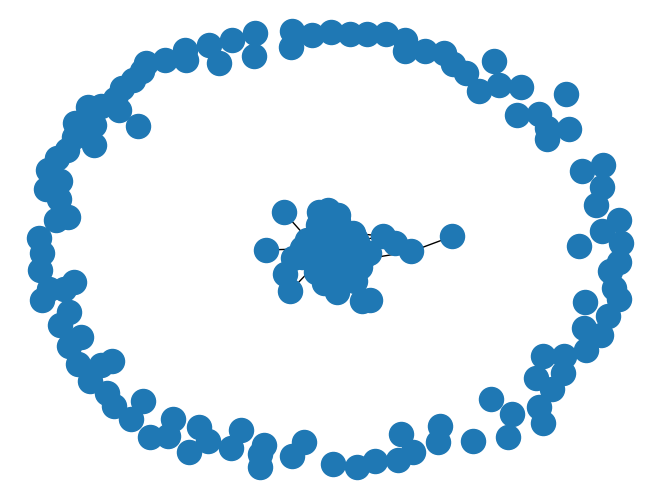

In [6]:
nx.draw(G)

In [7]:
df = pd.DataFrame(nx.adjacency_matrix(G).todense())
df.index = occ
df.columns = occ

In [8]:
df.to_csv('adjacency.csv')

In [9]:
print(f"Connected component is {len(max(nx.connected_components(G), key=len)) / len(G):.2%} of the occupations")

Connected component is 67.48% of the occupations


## Create Node Data

In [10]:
node_df = main_df.groupby('SOC_4_NAME').agg({
    'ID': 'count',
    'green': lambda x: np.sum(x) > 0,
    'INDUSTRY': lambda x: max(set(x).difference(set({'Employment activities', ''})), key=list(x).count)
})

node_df = pd.DataFrame({
    'Id': [o.replace(',','').lower() for o in list(node_df.index)],
    'Label': [o.replace(',','').lower() if node_df['ID'].values[i] > 1000 else '' for i, o in enumerate(list(node_df.index))],
    'count': node_df['ID'].values,
    'green': node_df['green'].values,
    'industry': [i if type(i) is str else '' for i in node_df['INDUSTRY']]
})

node_df.to_csv('node.csv', index=False)

In [11]:
edge_df = pd.DataFrame([{'Source': e[0], 'Target': e[1], 'Weight': e[2]} for e in edges])
edge_df.to_csv('edge.csv', index=False)

## Clustering

In [12]:
largest_component = max(nx.connected_components(G), key=len)
G2 = G.subgraph(largest_component)

In [13]:
comms = nx.community.asyn_fluidc(G2, 3, 100)

comm_map = {}
for i, c in enumerate(comms):
    for occ in c:
        comm_map[occ] = f"comm{i}"

In [14]:
node_df['community'] = node_df['Id'].map(lambda x: comm_map[x] if x in comm_map.keys() else '')
node_df.to_csv('node.csv', index=False)

## Peripheral Green Skills

In [29]:
target_df = node_df[node_df['green']].reset_index().copy()
target_df = target_df[target_df['community'] == 'comm1']
target_occs = target_df['Id'].values

clean_df = main_df[main_df['SOC_4_NAME'].map(lambda x: x.replace(',','').lower() in list(target_occs) + [
    'road construction operatives', 'civil engineers', 'construction and building trades supervisors', 'production managers and directors in construction'
])]
print(len(clean_df))

100614


In [16]:
dirty_df = main_df[main_df['INDUSTRY'].map(lambda x: x in [
    'oil_gas_manuf', 
    'coal_mining',
    'petrol_manuf'
])]
print(len(dirty_df))

946


In [30]:
def explodeList(df, measure, group, specify):

    df = df[[group, measure]].copy()
    df = df[df[group] == specify]

    df['value'] = df[measure].map(lambda x: '' if x is None else [y.strip() for y in x.replace('"', '').replace(",","").split('\n')[1:-1]])
    df['data_type'] = [measure for i in range(len(df))]

    return df[[group, 'data_type', 'value']].explode('value')

clean_skill_df = pd.DataFrame(columns=["green", 'data_type', 'value'])

def extract_skills(df):

    df2 = pd.DataFrame(columns=["green", 'data_type', 'value'])

    for i in [True, False]: 

        common = explodeList(df, 'COMMON_SKILLS_NAME', 'green', i)
        special = explodeList(df, 'SPECIALIZED_SKILLS_NAME', 'green', i)
        software = explodeList(df, 'SOFTWARE_SKILLS_NAME', 'green', i)
        certification = explodeList(df, 'CERTIFICATIONS_NAME', 'green', i)

        df2 = pd.concat([df2, common])
        df2 = pd.concat([df2, special])
        df2 = pd.concat([df2, software])
        df2 = pd.concat([df2, certification])

    return df2


In [31]:
main_skills_df = extract_skills(main_df.copy())

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_2102/2550059099.py:25: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df2 = pd.concat([df2, special])
/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_2102/2550059099.py:26: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df2 = pd.concat([df2, software])
/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_2102/2550059099.py:27: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df2 = pd.concat([df2, certification])
/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_2102/2550059099.py:24: FutureWarning: In a future version, object-d

In [19]:
clean_skills_df = extract_skills(clean_df.copy())

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_2102/2550059099.py:25: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df2 = pd.concat([df2, special])
/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_2102/2550059099.py:26: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df2 = pd.concat([df2, software])
/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_2102/2550059099.py:27: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df2 = pd.concat([df2, certification])
/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_2102/2550059099.py:24: FutureWarning: In a future version, object-d

### Specialized SKills Comparison

In [34]:
main_skills_df[main_skills_df['data_type'] == 'SPECIALIZED_SKILLS_NAME']['value'].value_counts()[0:10]

Finance                              67446
Marketing                            61846
Accounting                           53980
Auditing                             51169
Key Performance Indicators (KPIs)    39410
Agile Methodology                    35200
Warehousing                          32725
Invoicing                            31380
Business Development                 30278
Nursing                              25984
Name: value, dtype: int64

In [35]:
clean_skills_df[clean_skills_df['data_type'] == 'SPECIALIZED_SKILLS_NAME']['value'].value_counts()[0:10]

Machinery                   8173
Mechanical Engineering      6195
Maintenance Engineering     5566
Electrical Engineering      5371
Warehousing                 4270
Forklift Truck              4094
Field Service Management    3672
Construction                2812
Electrical Wiring           2761
Housekeeping                2592
Name: value, dtype: int64

### Certification Comparison

In [38]:
main_skills_df[main_skills_df['data_type'] == 'CERTIFICATIONS_NAME']['value'].value_counts()[0:10]

Association Of Chartered Certified Accountants                       17082
Registered Nurse (RN)                                                16301
Chartered Institute Of Management Accountants (CIMA)                 10659
CSCS Card                                                             9854
Functional Skills Qualification                                       7167
Security Clearance                                                    5762
Post Graduate Certificate In Education (PGCE)                         4447
PRINCE2  (PRojects IN Controlled Environments 2)                      3676
Chartered Institute Of Personnel And Development (CIPD) Certified     2614
Nurse Practitioner (APRN-CNP)                                         2038
Name: value, dtype: int64

In [39]:
clean_skills_df[clean_skills_df['data_type'] == 'CERTIFICATIONS_NAME']['value'].value_counts()[0:10]

CSCS Card                                              4528
Security Clearance                                      623
Functional Skills Qualification                         588
Core Domestic Gas Safety (CCN1)                         328
Forklift Certification                                  221
Registered Nurse (RN)                                   219
Gas Meter Safety (MET1)                                 119
Association Of Chartered Certified Accountants          103
Smart Meter Installer Core (CMA1)                       100
Meter Operation Code Of Practice Agreement (MOCOPA)      90
Name: value, dtype: int64